In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

import time
import pandas as pd
import seaborn as sns

from auxfunctions import *
from implementations import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
def rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12):
    return (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)

Parameters

In [3]:
d = 2
n = 1000
n_test = 100
sup = 1

nu_1 = 1/2
nu_2 = 1/2
theta_1 = 10
theta_2 = 8

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.8

In [4]:
def boxplots_2(data, title=''):
    plt.figure(figsize=(12,5))
    sns.boxplot(data=data[data['N'] == n], 
                x='METHOD', y='RMSE', width=0.2, linecolor='k', 
                boxprops={"facecolor": 'gray'}, zorder=2, ax=plt.gca())

    sns.boxplot(data=data[data['N'] != n],
                x='N', y='RMSE', hue='METHOD', width=0.6,
                palette='pastel', linecolor='k',
                zorder=2, ax=plt.gca())

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='METHOD')
    plt.xlabel('N')
    plt.title(title)
    plt.axhline(data[data['METHOD'] == 'coK']['RMSE'].median(), ls='--', c='r', lw=1)
    plt.grid(axis='y', zorder=1);

# $a = (0.1, 0.1)^\top$

In [5]:
a_x = .1
a = np.array([a_x, a_x])

In [6]:
Ks = [
#   K,     # N
    10,    # 100
    20,    # 50
    50,    # 20
    100,   # 10
    200,   # 5
]

Ns = [n // K for K in Ks]

aux = [] # METHOD, N, K, TIME, RMSE
num_replications = 50

In [7]:
for _ in range(num_replications):
    start = time.time()
    X_2 = gen_observation_points(d, n, sup)
    X_1 = np.concatenate([gen_observation_points(d, n_test, sup-a_x), X_2])
    
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12, a)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]
    sigma = sigma[n_test:, :][:, n_test:]

    for N, n_clusters in zip(Ns, Ks):
        # coKNN
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()
        aux.append(['coKNN', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM
        A_1, A_2 = gen_As(X_1, X_2, n_clusters)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    # CO KRIGING
    start_time = time.time()
    Y_pred = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma, a)
    end_time = time.time()
    aux.append(['coK', n, 1, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    end = time.time()
    print(f'{_}: {(end-start)//60:.0f}min {(end-start)%60:.0f}s')

0: 0min 21s
1: 0min 28s
2: 0min 46s
3: 0min 22s
4: 0min 20s
5: 0min 20s
6: 0min 19s
7: 0min 19s
8: 0min 19s
9: 0min 23s
10: 0min 20s
11: 0min 19s
12: 0min 19s
13: 0min 27s
14: 2min 14s
15: 1min 0s
16: 1min 9s
17: 0min 20s
18: 0min 19s
19: 0min 19s
20: 0min 22s
21: 0min 19s
22: 0min 20s
23: 0min 19s
24: 0min 19s
25: 0min 19s
26: 0min 19s
27: 0min 20s
28: 0min 19s
29: 0min 20s
30: 0min 19s
31: 0min 19s
32: 0min 20s
33: 0min 20s
34: 0min 20s
35: 0min 20s
36: 0min 19s
37: 0min 19s
38: 0min 19s
39: 0min 19s
40: 0min 19s
41: 0min 19s
42: 0min 19s
43: 0min 19s
44: 0min 19s
45: 0min 19s
46: 0min 20s
47: 0min 19s
48: 0min 19s
49: 0min 20s


In [8]:
aux = pd.DataFrame(aux, columns=['METHOD', 'N', 'K', 'TIME', 'RMSE'])

aux['a'] = f'{a}'

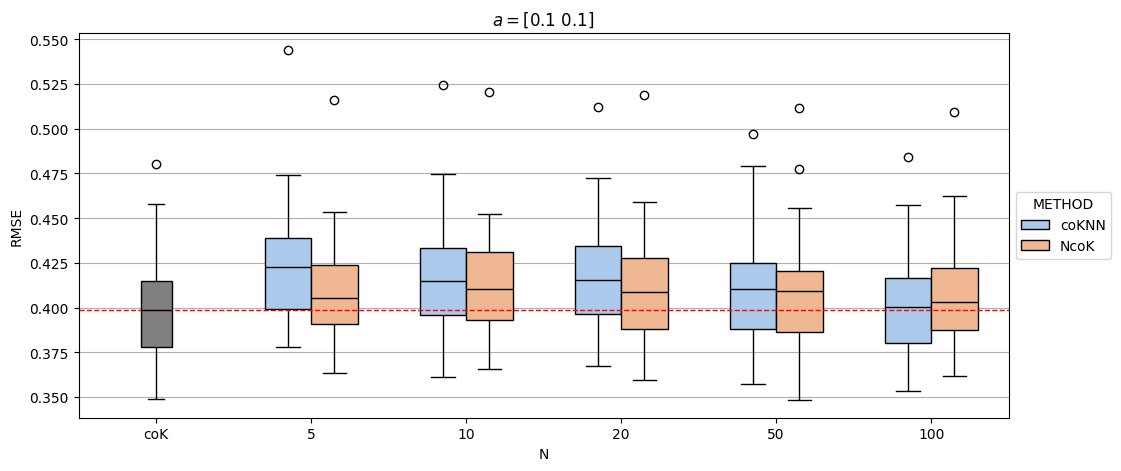

In [9]:
boxplots_2(aux, f'$a=${a}')

In [10]:
aux.to_csv('asymmetric.csv', index=False, sep=';')

# $a = (0.3, 0.3)^\top$

In [11]:
a_x = .3
a = np.array([a_x, a_x])

In [12]:
Ks = [
#   K,     # N
    10,    # 100
    20,    # 50
    50,    # 20
    100,   # 10
    200,   # 5
]

Ns = [n // K for K in Ks]

aux = [] # METHOD, N, K, TIME, RMSE
num_replications = 50

In [13]:
for _ in range(num_replications):
    start = time.time()
    X_2 = gen_observation_points(d, n, sup)
    X_1 = np.concatenate([gen_observation_points(d, n_test, sup-a_x), X_2])
    
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12, a)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]
    sigma = sigma[n_test:, :][:, n_test:]

    for N, n_clusters in zip(Ns, Ks):
        # coKNN
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()
        aux.append(['coKNN', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM
        A_1, A_2 = gen_As(X_1, X_2, n_clusters)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    # CO KRIGING
    start_time = time.time()
    Y_pred = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma, a)
    end_time = time.time()
    aux.append(['coK', n, 1, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    end = time.time()
    print(f'{_}: {(end-start)//60:.0f}min {(end-start)%60:.0f}s')

0: 0min 21s
1: 0min 21s
2: 0min 19s
3: 0min 19s
4: 0min 19s
5: 0min 19s
6: 0min 19s
7: 0min 19s
8: 0min 19s
9: 0min 19s
10: 0min 19s
11: 0min 19s
12: 0min 19s
13: 0min 19s
14: 0min 19s
15: 0min 19s
16: 0min 19s
17: 0min 19s
18: 0min 19s
19: 0min 19s
20: 0min 20s
21: 0min 19s
22: 0min 19s
23: 0min 20s
24: 0min 19s
25: 0min 19s
26: 0min 19s
27: 0min 19s
28: 0min 19s
29: 0min 19s
30: 0min 19s
31: 0min 20s
32: 0min 19s
33: 0min 19s
34: 0min 19s
35: 0min 19s
36: 0min 19s
37: 0min 19s
38: 0min 19s
39: 0min 19s
40: 0min 19s
41: 0min 19s
42: 0min 19s
43: 0min 19s
44: 0min 19s
45: 0min 19s
46: 0min 19s
47: 0min 20s
48: 0min 22s
49: 0min 19s


In [14]:
aux = pd.DataFrame(aux, columns=['METHOD', 'N', 'K', 'TIME', 'RMSE'])

aux['a'] = f'{a}'

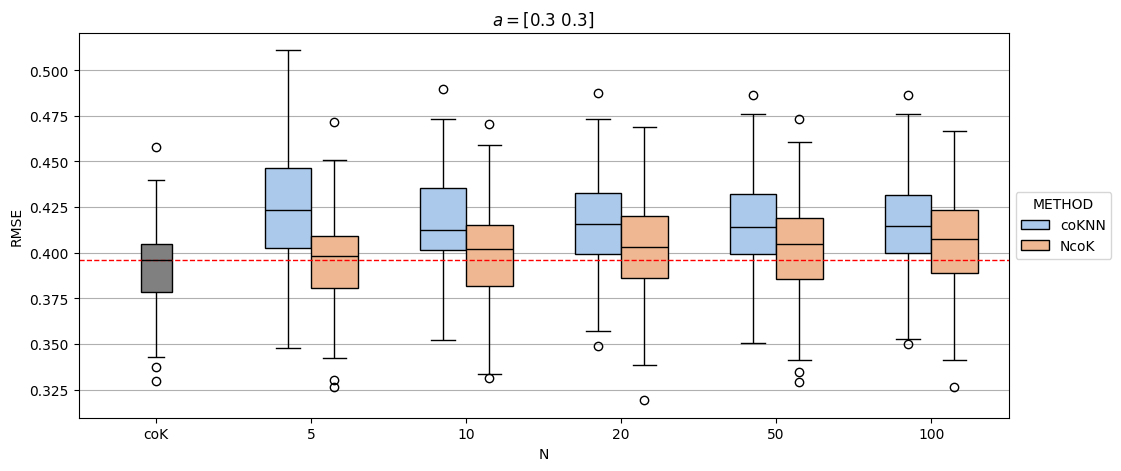

In [15]:
boxplots_2(aux, f'$a=${a}')

In [16]:
data = pd.read_csv('asymmetric.csv', sep=';')
data = pd.concat([data, aux], axis=0)
data.to_csv('asymmetric.csv', index=False, sep=';')

# $a = (0.5, 0.5)^\top$

In [17]:
a_x = .5
a = np.array([a_x, a_x])

In [18]:
Ks = [
#   K,     # N
    10,    # 100
    20,    # 50
    50,    # 20
    100,   # 10
    200,   # 5
]

Ns = [n // K for K in Ks]

aux = [] # METHOD, N, K, TIME, RMSE
num_replications = 50

In [19]:
for _ in range(num_replications):
    start = time.time()
    X_2 = gen_observation_points(d, n, sup)
    X_1 = np.concatenate([gen_observation_points(d, n_test, sup-a_x), X_2])
    
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12, a)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]
    sigma = sigma[n_test:, :][:, n_test:]

    for N, n_clusters in zip(Ns, Ks):
        # coKNN
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()
        aux.append(['coKNN', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM
        A_1, A_2 = gen_As(X_1, X_2, n_clusters)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    # CO KRIGING
    start_time = time.time()
    Y_pred = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma, a)
    end_time = time.time()
    aux.append(['coK', n, 1, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    end = time.time()
    print(f'{_}: {(end-start)//60:.0f}min {(end-start)%60:.0f}s')

0: 0min 21s
1: 0min 19s
2: 0min 19s
3: 0min 20s
4: 0min 19s
5: 0min 19s
6: 0min 19s
7: 0min 19s
8: 0min 19s
9: 0min 19s
10: 0min 20s
11: 0min 21s
12: 0min 19s
13: 0min 20s
14: 0min 19s
15: 0min 20s
16: 0min 19s
17: 0min 19s
18: 0min 19s
19: 0min 19s
20: 0min 19s
21: 0min 19s
22: 0min 19s
23: 0min 19s
24: 0min 19s
25: 0min 19s
26: 0min 19s
27: 0min 19s
28: 0min 19s
29: 0min 19s
30: 0min 19s
31: 0min 19s
32: 0min 19s
33: 0min 19s
34: 0min 19s
35: 0min 19s
36: 0min 19s
37: 0min 19s
38: 0min 19s
39: 0min 19s
40: 0min 19s
41: 0min 19s
42: 0min 19s
43: 0min 20s
44: 0min 21s
45: 0min 19s
46: 0min 19s
47: 0min 19s
48: 0min 19s
49: 0min 19s


In [20]:
aux = pd.DataFrame(aux, columns=['METHOD', 'N', 'K', 'TIME', 'RMSE'])

aux['a'] = f'{a}'

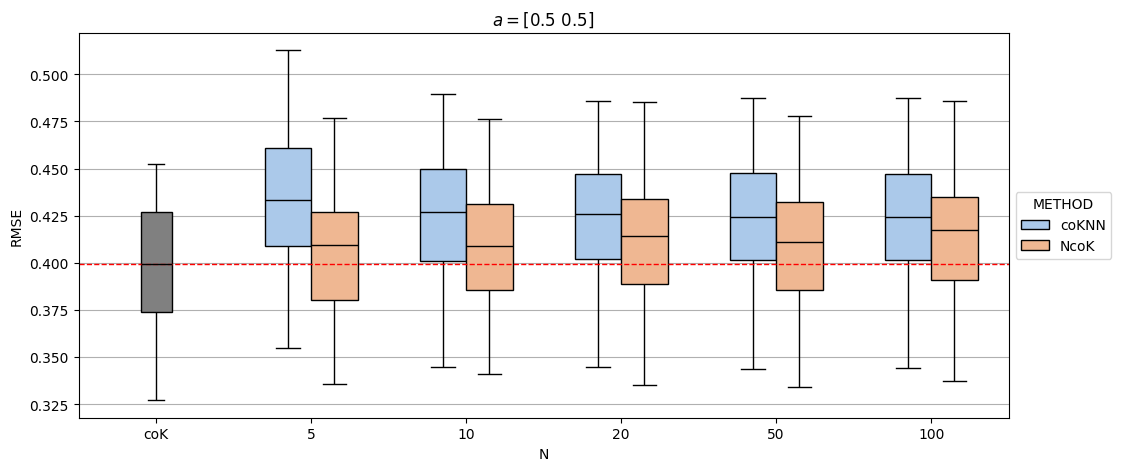

In [21]:
boxplots_2(aux, f'$a=${a}')

In [22]:
data = pd.read_csv('asymmetric.csv', sep=';')
data = pd.concat([data, aux], axis=0)
data.to_csv('asymmetric.csv', index=False, sep=';')

# $a = (0.8, 0.8)^\top$

In [23]:
a_x = .8
a = np.array([a_x, a_x])

In [24]:
Ks = [
#   K,     # N
    10,    # 100
    20,    # 50
    50,    # 20
    100,   # 10
    200,   # 5
]

Ns = [n // K for K in Ks]

aux = [] # METHOD, N, K, TIME, RMSE
num_replications = 50

In [25]:
for _ in range(num_replications):
    start = time.time()
    X_2 = gen_observation_points(d, n, sup)
    X_1 = np.concatenate([gen_observation_points(d, n_test, sup-a_x), X_2])
    
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12, a)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]
    sigma = sigma[n_test:, :][:, n_test:]

    for N, n_clusters in zip(Ns, Ks):
        # coKNN
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()
        aux.append(['coKNN', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

        # NcoK KM
        A_1, A_2 = gen_As(X_1, X_2, n_clusters)
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12, a)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        aux.append(['NcoK', N, n_clusters, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    # CO KRIGING
    start_time = time.time()
    Y_pred = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma, a)
    end_time = time.time()
    aux.append(['coK', n, 1, end_time-start_time, root_mean_squared_error(Y_test, Y_pred)])

    end = time.time()
    print(f'{_}: {(end-start)//60:.0f}min {(end-start)%60:.0f}s')

0: 0min 20s
1: 0min 19s
2: 0min 19s
3: 0min 19s
4: 0min 19s
5: 0min 19s
6: 0min 19s
7: 0min 19s
8: 0min 19s
9: 0min 19s
10: 0min 19s
11: 0min 19s
12: 0min 20s
13: 0min 20s
14: 0min 19s
15: 0min 19s
16: 0min 19s
17: 0min 19s
18: 0min 19s
19: 0min 20s
20: 0min 19s
21: 0min 20s
22: 0min 20s
23: 0min 19s
24: 0min 19s
25: 0min 19s
26: 0min 20s
27: 0min 20s
28: 0min 20s
29: 0min 20s
30: 0min 19s
31: 0min 19s
32: 0min 20s
33: 0min 19s
34: 0min 19s
35: 0min 19s
36: 0min 19s
37: 0min 20s
38: 0min 19s
39: 0min 19s
40: 0min 19s
41: 0min 21s
42: 0min 19s
43: 0min 21s
44: 0min 19s
45: 0min 19s
46: 0min 19s
47: 0min 19s
48: 0min 19s
49: 0min 19s


In [26]:
aux = pd.DataFrame(aux, columns=['METHOD', 'N', 'K', 'TIME', 'RMSE'])

aux['a'] = f'{a}'

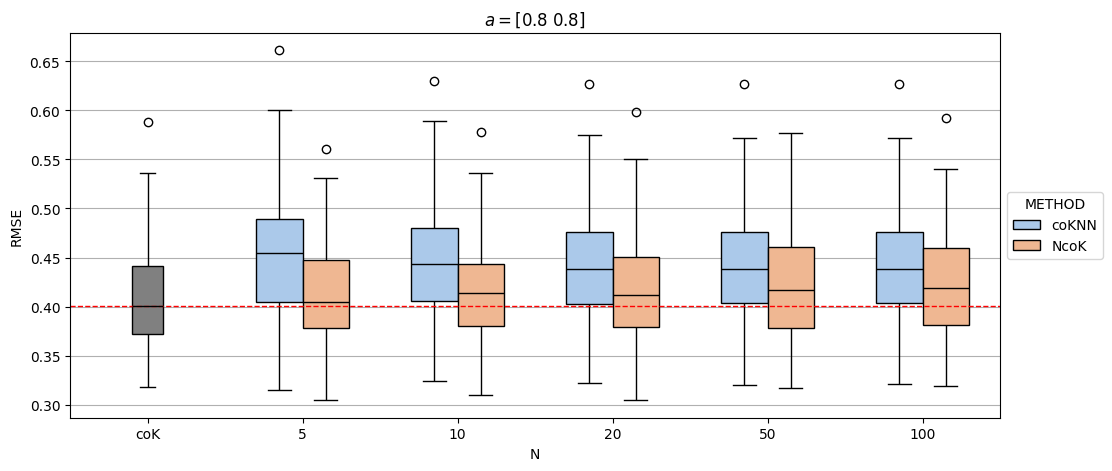

In [27]:
boxplots_2(aux, f'$a=${a}')

In [28]:
data = pd.read_csv('asymmetric.csv', sep=';')
data = pd.concat([data, aux], axis=0)
data.to_csv('asymmetric.csv', index=False, sep=';')